# How Image & Text Vectors influence VQA Performances

This is a follow-up to the [discussion](https://github.com/iamaaditya/VQA_Demo/issues/4) @iamaaditya on how image & text vectors could influence the VQA result.

Please also see [USECASE - Visual Q & A by Keras](http://localhost:8888/notebooks/USECASE%20-%20Visual%20Q%20%26%20A%20by%20Keras.ipynb) for a context.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

In [2]:
import keras
print keras.__version__

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.
1.0.6


Using gpu device 0: GeForce GTX 980M (CNMeM is disabled, cuDNN 5005)


In [3]:
import numpy as np

from keras import models, layers, optimizers, metrics
from keras.utils import visualize_util
from keras.preprocessing import sequence

from scipy.misc import imresize
from skimage.io import imread
from skimage.util import img_as_ubyte

## Image Vector Model

In [4]:
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D

def build_vgg16(weights_file = None):
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    
    if weights_file is not None:
        model.load_weights(weights_file)
    
    return model

image_model = build_vgg16("../data/vgg16_keras/vgg16_weights.h5")

## pop out the last two layers
image_model.pop()
image_model.pop()

image_model.compile(loss = "mse", optimizer = "sgd")


In [5]:
def img2vec(img):
    ## preprocessing
    img = imresize(img, (224, 224))
    img = img_as_ubyte(img).astype("float32")
    
    ## RGB to BGR
    img = img[:, :, ::-1]
    
    ## zero-centerized is not used when creating the model, so ignored
    ## see author's clarification here 
    ## https://github.com/iamaaditya/VQA_Demo/issues/4
#     img[:,:,0] -= 103.939
#     img[:,:,1] -= 116.779
#     img[:,:,2] -= 123.68

    ## theano format
    img = img.transpose((2, 0, 1))
    
    img_batch = np.expand_dims(img, axis = 0)
    ## debug image models...
    vec = image_model.predict(img_batch)
    return vec

## Word Vector Model

In [6]:
## doesnt work with my spacy version
## see disucussion here https://github.com/spacy-io/spaCy/issues/338 to fix it
import spacy
word_embeddings = spacy.load("en", vectors='en_glove_cc_300_1m_vectors')

In [7]:
import re
def txt2vec(text):
    """return a sequence of embedding vectors as the representation of text
    It won't be able to be used directly with image vectors, but LSTM will
    further reduce it to a single vector - will be discussed below
    """
    text = unicode(text)
    wordpat = re.compile(r"\w+")
    ## need to pad the sequence to 30 tokens long for VQA model
    vecs = np.zeros((30, 300), dtype = "float32") 
    for i, w in enumerate(wordpat.findall(text)):
        vecs[i, :] = word_embeddings(w).vector
    return np.expand_dims(vecs, axis = 0)

In [8]:
txt_vec = txt2vec(u"What color is the roof?")
txt_vec.shape

(1, 30, 300)

## Putting Image and Word Vectors Together
- Use the pretrained model provided [here](https://github.com/iamaaditya/VQA_Demo)

In [9]:
from keras.layers import Reshape, LSTM, Merge, Dense, Activation, Dropout
from keras.models import Sequential
def VQA_MODEL():
    image_feature_size          = 4096
    word_feature_size           = 300
    number_of_LSTM              = 3
    number_of_hidden_units_LSTM = 512
    max_length_questions        = 30
    number_of_dense_layers      = 3
    number_of_hidden_units      = 1024
    activation_function         = 'tanh'
    dropout_pct                 = 0.5


    # Image model
    model_image = Sequential()
    model_image.add(Reshape((image_feature_size,), input_shape=(image_feature_size,)))

    # Language Model
    model_language = Sequential()
    model_language.add(LSTM(number_of_hidden_units_LSTM, 
                            return_sequences=True, 
                            input_shape=(max_length_questions, word_feature_size)))
    model_language.add(LSTM(number_of_hidden_units_LSTM, 
                            return_sequences=True))
    model_language.add(LSTM(number_of_hidden_units_LSTM, 
                            return_sequences=False))

    # combined model
    model = Sequential()
    model.add(Merge([model_language, model_image], mode='concat', concat_axis=1))

    for _ in xrange(number_of_dense_layers):
        model.add(Dense(number_of_hidden_units, init='uniform'))
        model.add(Activation(activation_function))
        model.add(Dropout(dropout_pct))

    model.add(Dense(1000))
    model.add(Activation('softmax'))

    return model

#vqa_model = models.model_from_json(open("../data/vqa-demo/VQA_MODEL.json").read())
vqa_model = VQA_MODEL()
vqa_model.load_weights("../data/vqa-demo/VQA_MODEL_WEIGHTS.hdf5")
vqa_model.compile(loss = "categorical_crossentropy", 
                  optimizer = "rmsprop", 
                  metrics=["accuracy"])

In [10]:
from sklearn.externals import joblib
label_encoder = joblib.load("../data/vqa-demo/FULL_labelencoder_trainval.pkl")

In [11]:
## putting together
def vqa(img_vector, txt_vector):
    #txt_vector = txt2vec(question)
    #img_vector = img2vec(img)
    scores = vqa_model.predict([txt_vector, img_vector])
    top5 = scores.argsort(axis = 1)[:, -5:][:, ::-1]
    top5_labels = label_encoder.inverse_transform(top5).ravel()
    top5_probs = scores[:, top5].ravel()
    answer = "\n".join(["%s(%.2f)" % (label, prob) for label, prob in zip(top5_labels, top5_probs)])
    return "Answers: %s" % answer

## Test Images and Questions

In [12]:
image_urls = [
    "https://raw.githubusercontent.com/iamaaditya/VQA_Demo/master/test.jpg"
    , "https://images-na.ssl-images-amazon.com/images/G/01/img15/pet-products/small-tiles/30423_pets-products_january-site-flip_3-cathealth_short-tile_592x304._CB286975940_.jpg"
    , "https://upload.wikimedia.org/wikipedia/commons/2/29/33_ACPS_Atlanta_1996_Swimming_Jeff_Hardy.jpg"
    , "http://fulldesktopbackgrounds.com/wp-content/uploads/2015/01/Wallpapers-Hd-Free-1.jpg"
]
questions = [
    "What vehicle is in the picture?"
    , "How many cats are there?"
    , "What sport is this?"
    , "What color is the flower?"
]

## VQA Expected Results

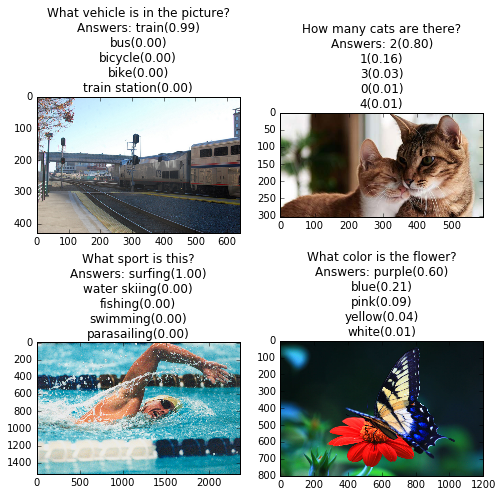

In [13]:
fig, axes = plt.subplots(2, 2, figsize = (8, 8))
axes = axes.ravel()

for ax, url, q in zip(axes, image_urls, questions):
    img = imread(url)
    img_vec = img2vec(img)
    txt_vec = txt2vec(q)
    a = vqa(img_vec, txt_vec)
    ax.imshow(img)
    ax.set_title("%s\n%s" % (q,a))

## VQA Results with translation-noise in Image Vectors
- Add random noises to RGB channel
- Here I choose to change the raw images than image vectors from VGG because I want to make the effect "comparable" with the text vectors: Raw Image through nonlinear CNN becomes Image Vector, and Text Vector through nonlinear LSTM becomes new Text Vector

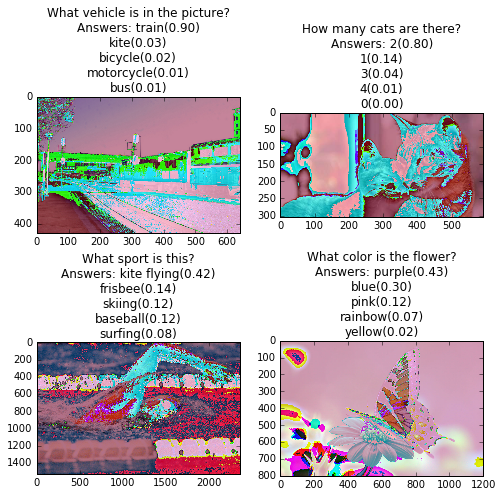

In [14]:
np.random.seed(314)

## 50 to 125 random shift for RGB channel
noise = np.random.randint(50, 125, size = 3).astype(np.ubyte)

fig, axes = plt.subplots(2, 2, figsize = (8, 8))
axes = axes.ravel()

for ax, url, q in zip(axes, image_urls, questions):
    img = imread(url)
    for i in xrange(3):
        img[:,:,i] -= noise[i]
    img_vec = img2vec(img)
    txt_vec = txt2vec(q)
    a = vqa(img_vec, txt_vec)
    ax.imshow(img)
    ax.set_title("%s\n%s" % (q,a))

***Most answers are still close to the original ones. One possibility is that detection of trains, number of animals are mainly based on "shape" features. However the sports questions is wrong because it might depend on detecting "water" features with exact "blue" values.***

***But most importantly, the answers are still in the "right" group, e.g., vehicles, numbers, sports and colors***

## VQA Results with translation-noise in Text Vectors

Add random noise to text vector dimension

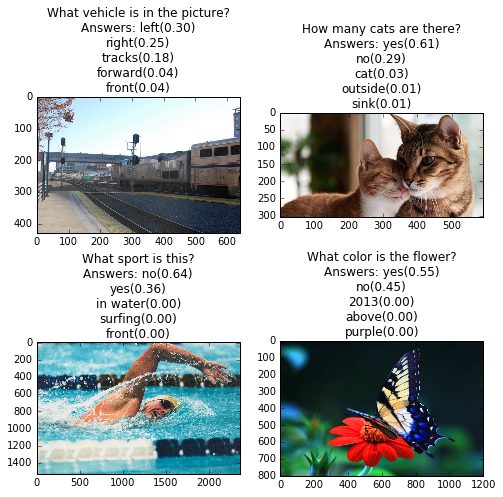

In [17]:
np.random.seed(314)

## group 300 dimensions into 3 groups and randomly apply a translation
## to each group separately

noise = 1.5 * np.random.rand(3).astype(np.float32)
index = np.random.permutation(300).reshape(3, -1)


fig, axes = plt.subplots(2, 2, figsize = (8, 8))
axes = axes.ravel()

for ax, url, q in zip(axes, image_urls, questions):
    img = imread(url)
    img_vec = img2vec(img)
    txt_vec = txt2vec(q)
    for i in xrange(3):
        txt_vec[:, :, index[i]] -= noise[i]
    a = vqa(img_vec, txt_vec)
    ax.imshow(img)
    ax.set_title("%s\n%s" % (q,a))

***Here we can see that the translation noise might have a bigger influence for VQA, as the given answers may not even be in the same group. This could be caused by the sparseness in the text vector space - see [discussion](https://github.com/iamaaditya/VQA_Demo/issues/4) by @iamaaditya***


***But if we only change a few dimensions of text space, the result is actually robust to the noise. See below***

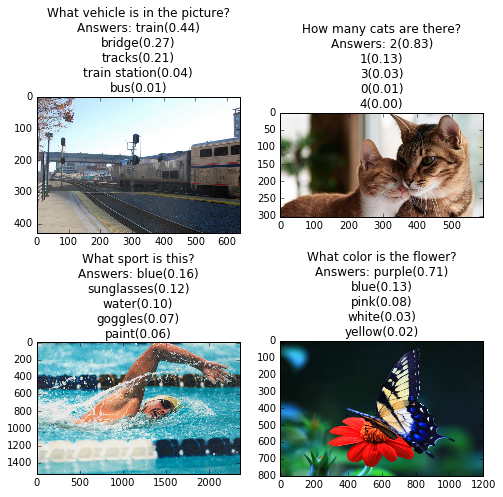

In [132]:
np.random.seed(314)

ndim = 15
## only add noise to ndim out of 300 dimensions in text space

noise = 1.5 * np.random.rand(ndim).astype(np.float32)


fig, axes = plt.subplots(2, 2, figsize = (8, 8))
axes = axes.ravel()

for ax, url, q in zip(axes, image_urls, questions):
    img = imread(url)
    img_vec = img2vec(img)
    txt_vec = txt2vec(q)
    for i,d in enumerate(np.random.randint(0, 300, ndim)):
        txt_vec[:, :, d] -= noise[i]
    a = vqa(img_vec, txt_vec)
    ax.imshow(img)
    ax.set_title("%s\n%s" % (q,a))

## VQA Results with permutation-noise in Image Vectors
- Randomly permutate the RGB channel

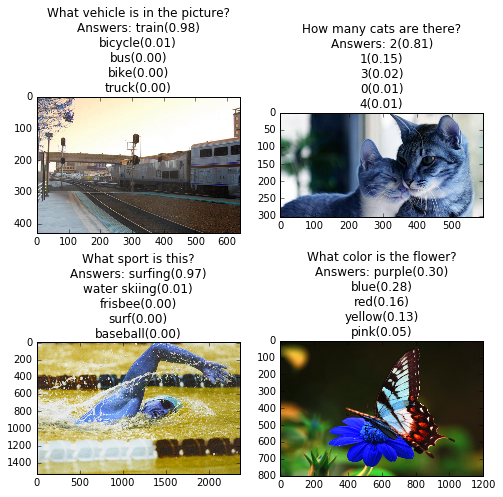

In [115]:
np.random.seed(314)

## random permutate color channels
noise = np.random.permutation(3)

fig, axes = plt.subplots(2, 2, figsize = (8, 8))
axes = axes.ravel()

for ax, url, q in zip(axes, image_urls, questions):
    img = imread(url)
    img = img[:,:,noise]
    img_vec = img2vec(img)
    txt_vec = txt2vec(q)
    a = vqa(img_vec, txt_vec)
    ax.imshow(img)
    ax.set_title("%s\n%s" % (q,a))

## VQA Results with permutation-noise in Text Vectors

Randomly permutate text vector dimensions

In [ ]:
np.random.seed(314)

## randomly ndim features to permutate
ndim = 10
i = np.random.randint(0, 300, ndim)

fig, axes = plt.subplots(2, 2, figsize = (8, 8))
axes = axes.ravel()

for ax, url, q in zip(axes, image_urls, questions):
    img = imread(url)
    img_vec = img2vec(img)
    txt_vec = txt2vec(q)
    txt_vec[:,:,i] = txt_vec[:,:,np.random.permutation(i)]
    a = vqa(img_vec, txt_vec)
    ax.imshow(img)
    ax.set_title("%s\n%s" % (q,a))

***Interestingly, the VQA model, and the VGG, Glove vector models underneath, are quite robust to the small changes in both the image and text inputs, which might be an indicator of good features that will genearlize well.***